In [2]:
%matplotlib inline
import nengo
import numpy as np
import pylab

In [248]:

model = nengo.Network()
with model:
    stim = nengo.Node(-0.1)
    
    decide = nengo.Node(lambda t: 1 if t>0.5 else 0)
    
    ens = nengo.Ensemble(n_neurons=500, dimensions=3, radius=1.7)
    
    nengo.Connection(stim, ens[0], synapse=None)
    nengo.Connection(decide, ens[1], synapse=None)
    
    def feedback(x):
        evidence, decide, decision = x
        
        if decide < 0.5:
            return 0
        else:
            if evidence + decision > 0:
                return 1
            else:
                return -1
    nengo.Connection(ens, ens[2], function=feedback, synapse=0.01)
    p = nengo.Probe(ens, synapse=0.03)
    
sim = nengo.Simulator(model)
sim.run(1)
    

Simulation finished in 0:00:01.                                                 


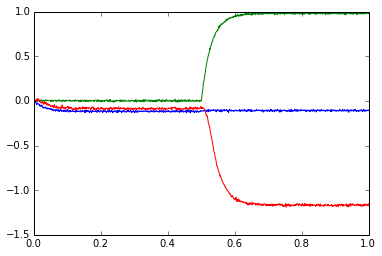

In [249]:
pylab.plot(sim.trange(), sim.data[p])

In [269]:

def test(value, n_neurons=500, T=0.4, feedback_synapse=0.01, evidence_scale=1, spike_noise=0.1):
    model = nengo.Network()
    with model:
        stim = nengo.Node(value)

        decide = nengo.Node(lambda t: 1 if t>T/2 else 0)

        ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=3, radius=1.7,
                            noise=nengo.processes.WhiteNoise(
                                        dist=nengo.dists.Gaussian(mean=0, std=spike_noise)))

        nengo.Connection(stim, ens[0], synapse=None)
        nengo.Connection(decide, ens[1], synapse=None)

        def feedback(x):
            evidence, decide, decision = x

            if decide < 0.5:
                return 0
            else:
                if evidence * evidence_scale + decision > 0:
                    return 1
                else:
                    return -1
        nengo.Connection(ens, ens[2], function=feedback, synapse=feedback_synapse)
        p = nengo.Probe(ens, synapse=0.03)

    sim = nengo.Simulator(model)
    sim.run(T, progress_bar=False)
    
    choice = sim.data[p][-1][2]
    return choice

test(0.24, evidence_scale=0.25, n_neurons=50, spike_noise=0.01, feedback_synapse=0.01)


-0.31805691602185637

-0.6 0.06
-0.54 0.13
-0.48 0.11
-0.42 0.2
-0.36 0.22
-0.3 0.19
-0.24 0.28
-0.18 0.31
-0.12 0.28
-0.06 0.39
0.0 0.43
0.06 0.6
0.12 0.53
0.18 0.63
0.24 0.65
0.3 0.77
0.36 0.82
0.42 0.8
0.48 0.87
0.54 0.96
0.6 0.88


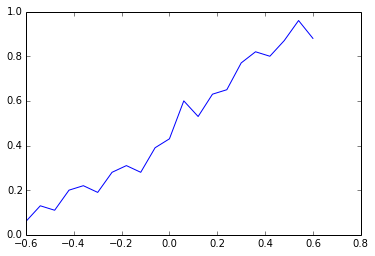

In [270]:
v = np.linspace(-0.6, 0.6, 21)

prob = []
raw = []
for vv in v:
    data = [test(vv, evidence_scale=0.25, n_neurons=50, spike_noise=0.002)>0 for i in range(100)]
    raw.append(data)
    p = np.mean(data)
    prob.append(p)
    print vv, p

pylab.plot(v, prob)    
    

In [271]:
import scipy.stats
def curve(x, noise):
    return scipy.stats.norm.cdf(x/noise)

p = scipy.optimize.curve_fit(curve, v, prob)
import ctn_benchmark
ci = np.array([ctn_benchmark.stats.bootstrapci(d, np.mean) for d in raw])



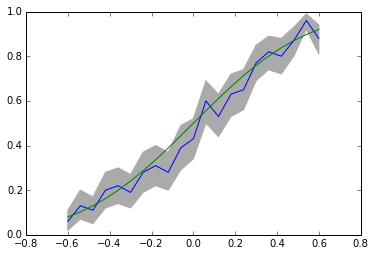

In [272]:
pylab.fill_between(v, ci[:,0], ci[:,1], color='#aaaaaa')
pylab.plot(v, prob)    
pylab.plot(v, curve(v, p[0][0]))
pylab.show()

In [273]:
print p[0][0]

0.426349598832
